In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
# from paddleocr import draw_ocr

In [3]:
sys.path.append(os.path.abspath("../"))

In [5]:
from jobs.sample_generation.image_utils import denormalise_box_coordinates, draw_boxes

### Read Sample and Boxes from API

In [6]:
document_id = 5

In [7]:
get_samples_url = f"http://localhost:8000/document_app/api/documents/{document_id}/get_samples/"

with requests.Session() as session:
    res_samples = session.get(get_samples_url)

if res_samples.status_code != 200:
    raise ValueError(f"cannot retrieve samples for document: {document_id}")
else:
    samples = res_samples.json()

In [8]:
sample = samples[0]
sample

{'id': 1813,
 'name': 'sample_0',
 'image': '/media/document_samples/sample_0_dPfpTnT.png',
 'template_document': 5}

In [9]:
sample_id = sample["id"]

In [10]:
get_sample_boxes_url = f"http://localhost:8000/document_app/api/sample_documents/{sample_id}/get_boxes/"

with requests.Session() as session:
    res_boxes = session.get(get_sample_boxes_url)

if res_boxes.status_code != 200:
    raise ValueError(f"cannot retrieve boxes for sample: {sample_id}")
else:
    boxes = res_boxes.json()

In [11]:
boxes

[{'id': 3388,
  'name': 'cognome_b',
  'label': 'UBFEVVSRO',
  'start_x_norm': 0.8159420289855073,
  'start_y_norm': 0.16407766990291262,
  'end_x_norm': 0.9666666666666667,
  'end_y_norm': 0.18058252427184465,
  'sample_document': 1813,
  'template_box': 19},
 {'id': 3389,
  'name': 'cognome',
  'label': 'NLIQ',
  'start_x_norm': 0.24202898550724639,
  'start_y_norm': 0.16407766990291262,
  'end_x_norm': 0.3101449275362319,
  'end_y_norm': 0.18155339805825244,
  'sample_document': 1813,
  'template_box': 18}]

In [12]:
with requests.Session() as session:
    res_image = session.get("http://localhost:8000/" + sample["image"])

if res_image.status_code == 200:
    sample_image = np.frombuffer(res_image.content, np.uint8)
    sample_image = cv2.imdecode(sample_image, cv2.IMREAD_COLOR)
else:
    raise ValueError(f"could not retrieve the image error: {res_image.status_code}")

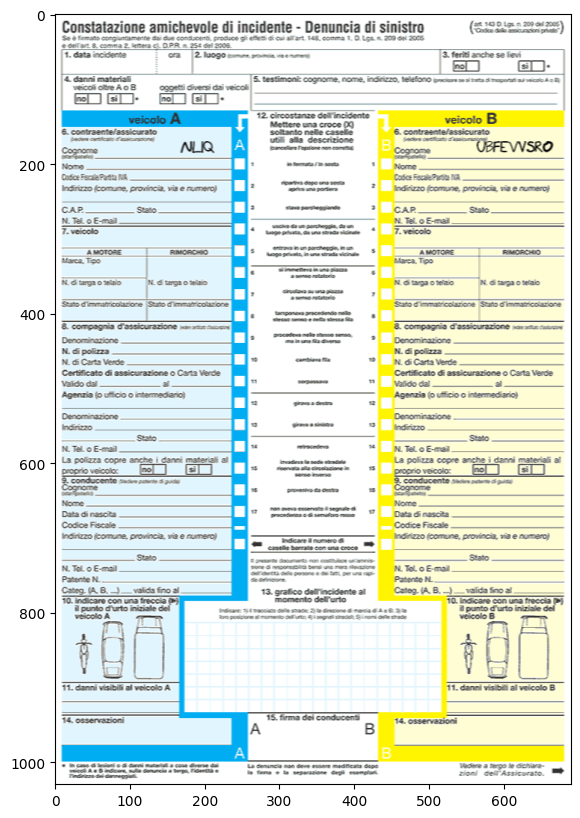

In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
doc_height = sample_image.shape[0]
doc_width = sample_image.shape[1]

In [15]:
box_coords = []

for box in boxes:
    start_x, start_y, end_x, end_y = denormalise_box_coordinates(box["start_x_norm"], box["start_y_norm"], 
                                                                 box["end_x_norm"], box["end_y_norm"],
                                                                 doc_width=doc_width, doc_height=doc_height)

    box_coords.append([[start_x, start_y], [end_x, start_y], [end_x, end_y], [start_x, end_y]])

In [16]:
box_coords

[[[563, 169], [667, 169], [667, 186], [563, 186]],
 [[167, 169], [214, 169], [214, 187], [167, 187]]]

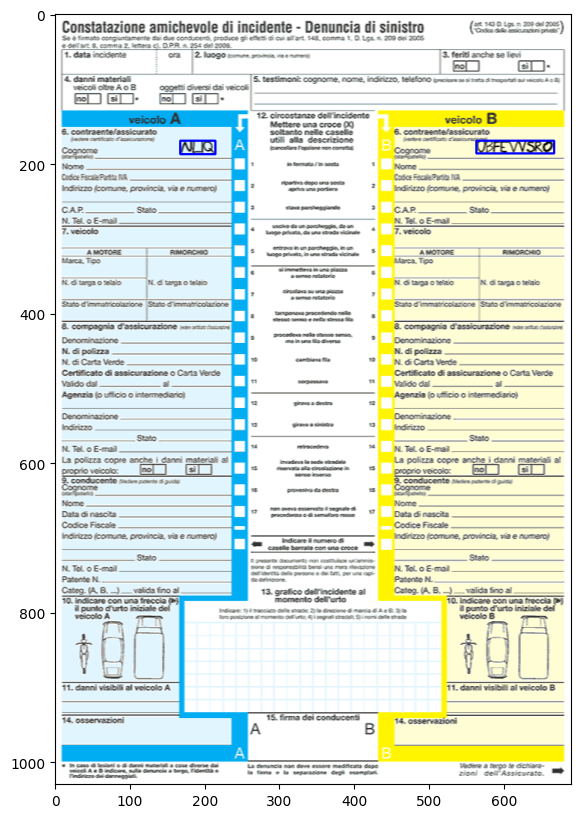

In [17]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(draw_boxes(sample_image, box_coords), cv2.COLOR_BGR2RGB))
plt.show()

### Apply Degradations

In [18]:
from jobs.sample_generation.image_degradations import GaussianBlurDegradation, \
    MotionBlurDegradation, GaussianNoiseDegradation, SaltPepperNoiseDegradation, BrightnessContrastDegradation, \
    WaveDistortionDegradation, ShadowDegradation, ColorFilterDegradation, DegradationsConfig

In [19]:
conf = DegradationsConfig(config_path="../jobs/sample_generation/config/degradation_config.yaml")

#### gaussian blur

In [20]:
conf.get_params_range(GaussianBlurDegradation)

{'kernel_size': [1, 2, 3]}

In [24]:
image_gaussian_blur = GaussianBlurDegradation(parameters={"kernel_size": 3}).apply(sample_image)

2025-04-14 00:06:30,583 - jobs.logging_config - DEBUG - Applying degradation GaussianBlurDegradation with parameters: {'kernel_size': 3}


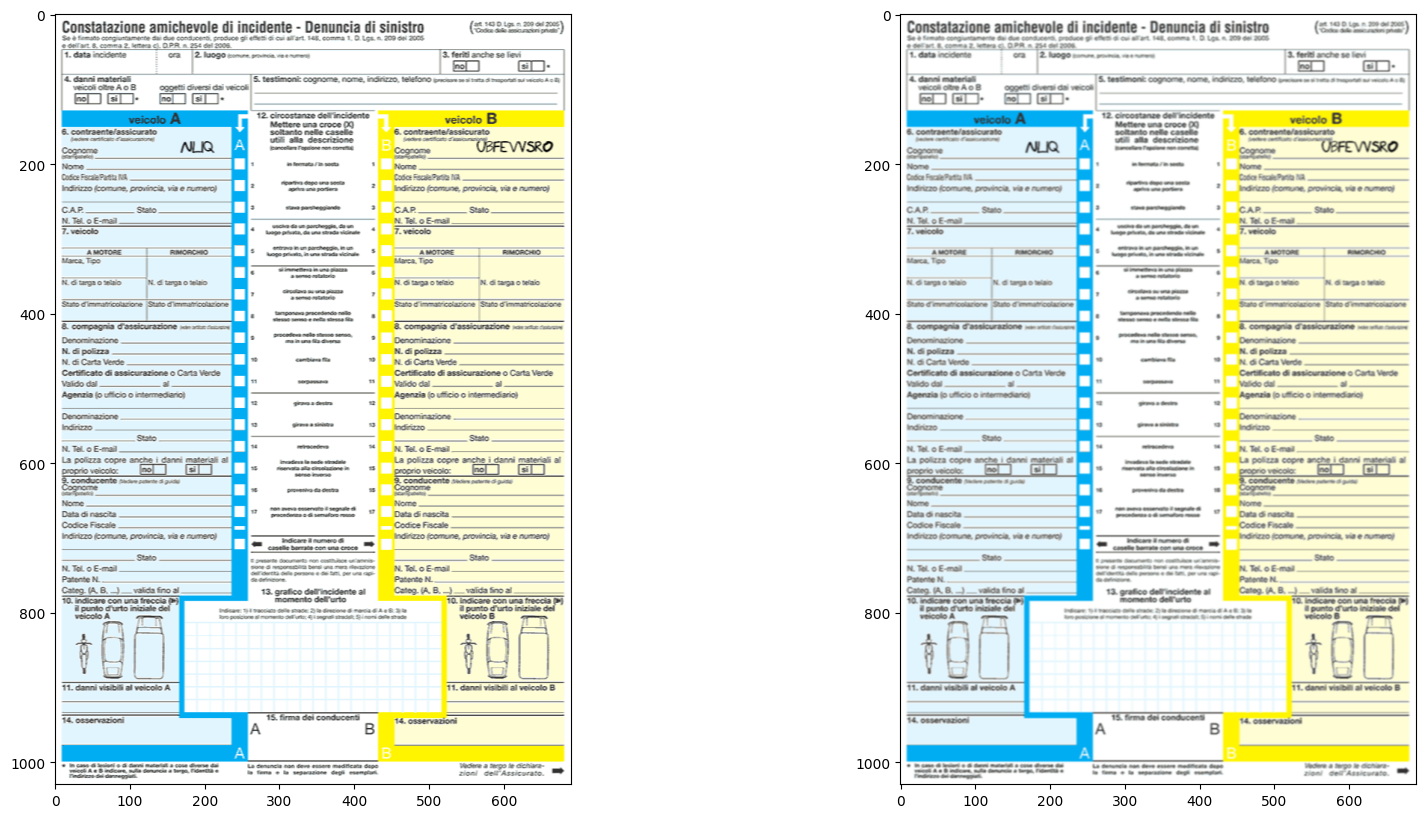

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(image_gaussian_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### motion blur

In [22]:
conf.get_params_range(MotionBlurDegradation)

{'kernel_size': [1, 2, 3]}

In [23]:
image_motion_blur = MotionBlurDegradation(parameters={"kernel_size": 3}).apply(sample_image)

2025-04-13 21:02:23,965 - logging_config - DEBUG - Applying degradation with parameters: {'kernel_size': 3}


In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(image_motion_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### gaussian noise

In [25]:
conf.get_params_range(GaussianNoiseDegradation)

{'mean': [0], 'std': [0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999]}

In [26]:
image_gaussian_noise = GaussianNoiseDegradation(parameters={"mean": 0, "std": 0.9}).apply(sample_image)

2025-04-13 21:02:24,956 - logging_config - DEBUG - Applying degradation with parameters: {'mean': 0, 'std': 0.9}


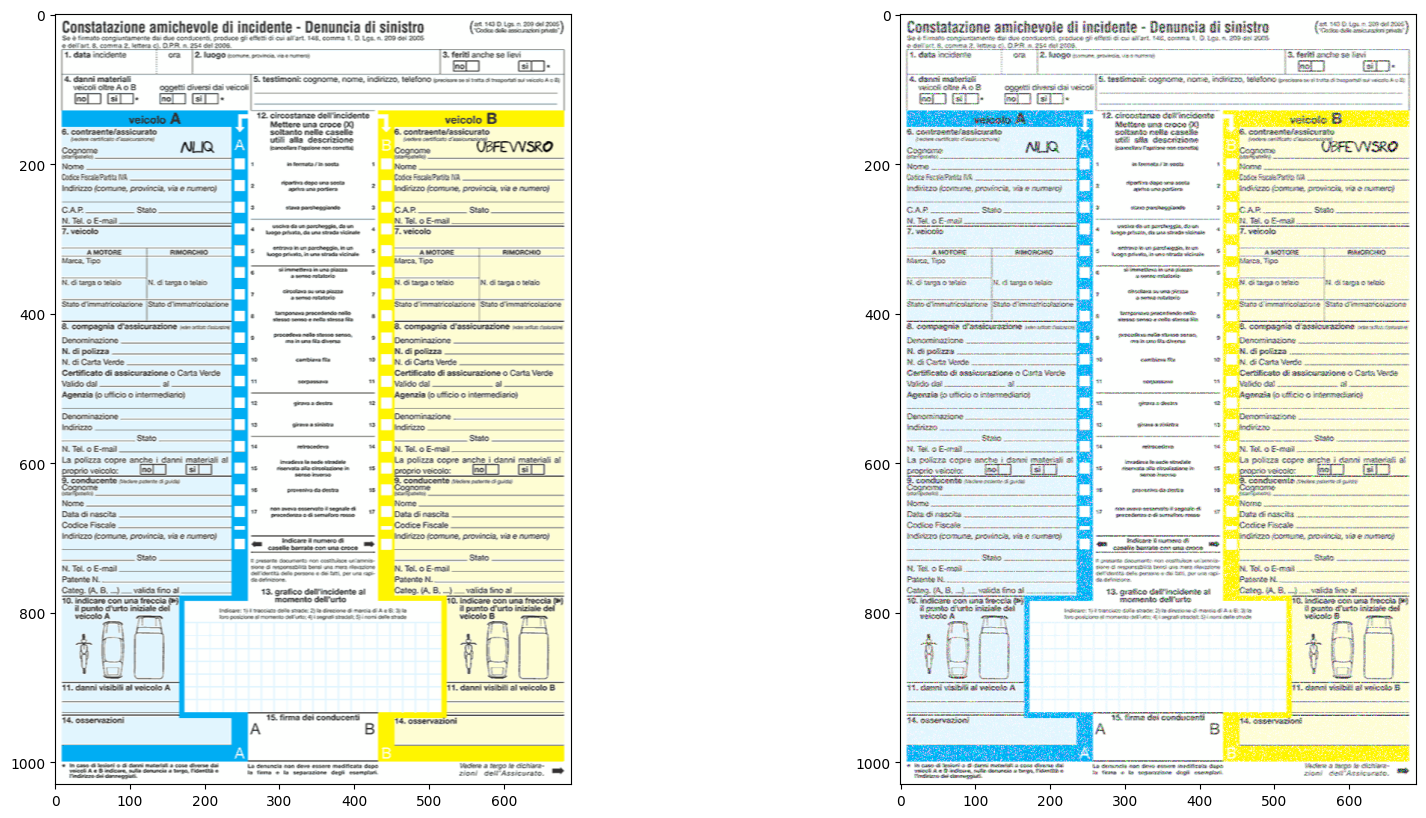

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(image_gaussian_noise, cv2.COLOR_BGR2RGB))
plt.show()

#### salt and pepper noise

In [28]:
conf.get_params_range(SaltPepperNoiseDegradation)

{'prob': [0.001,
  0.002,
  0.003,
  0.004,
  0.005,
  0.006,
  0.007,
  0.008,
  0.009000000000000001]}

In [29]:
image_salt_pepper_noise = SaltPepperNoiseDegradation(parameters={"prob": 0.009}).apply(sample_image)

2025-04-13 21:02:25,914 - logging_config - DEBUG - Applying degradation with parameters: {'prob': 0.009}


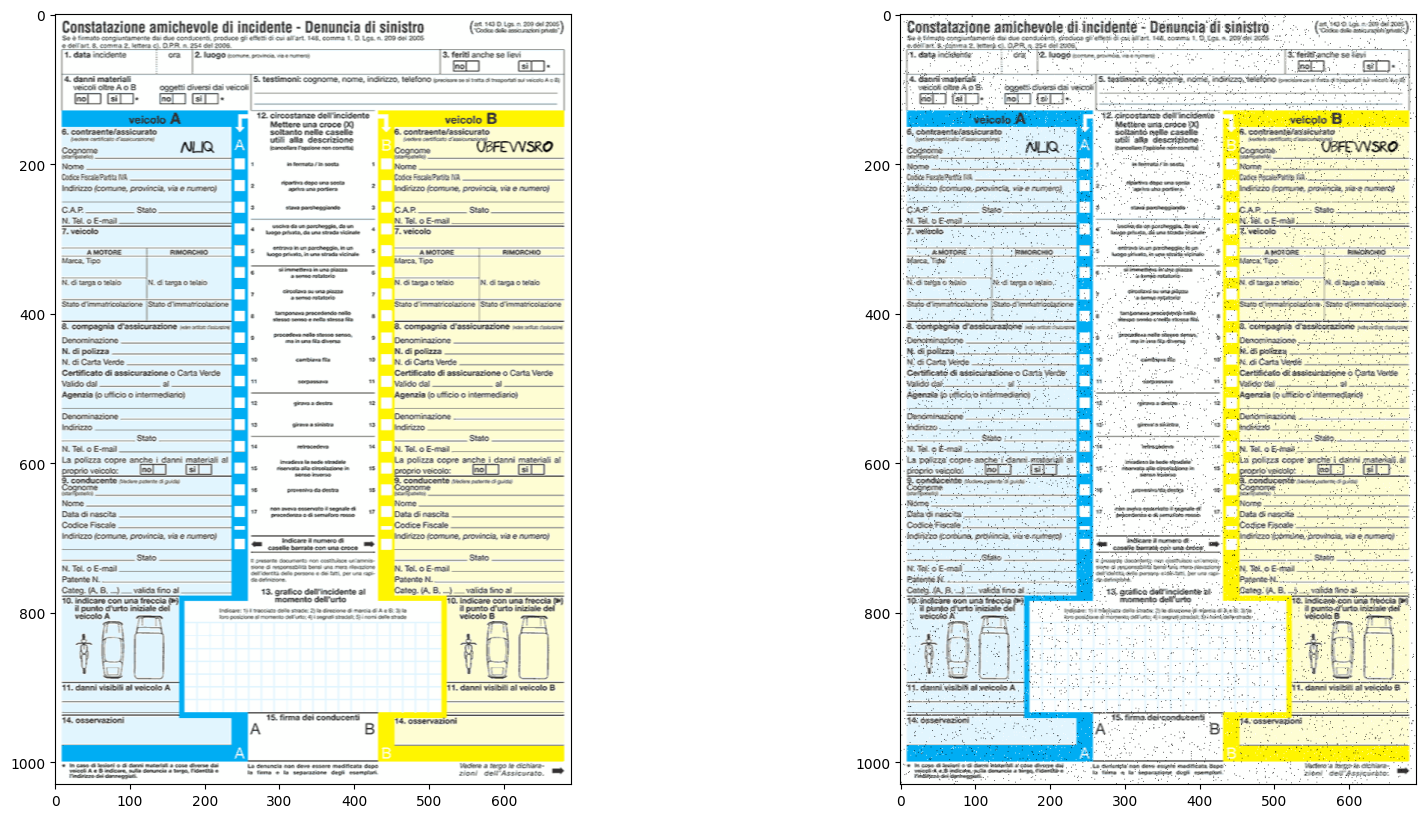

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(image_salt_pepper_noise, cv2.COLOR_BGR2RGB))
plt.show()

#### brightness and contrast

In [31]:
conf.get_params_range(BrightnessContrastDegradation)

{'alpha': [0.8, 0.9, 1.0, 1.1], 'beta': [-20, -15, -10, -5, 0, 5, 10, 15]}

In [32]:
new_image_brightness_contrast = BrightnessContrastDegradation(parameters={"alpha": 0.8,
                                                                          "beta": 10}).apply(sample_image)

2025-04-13 21:02:26,757 - logging_config - DEBUG - Applying degradation with parameters: {'alpha': 0.8, 'beta': 10}


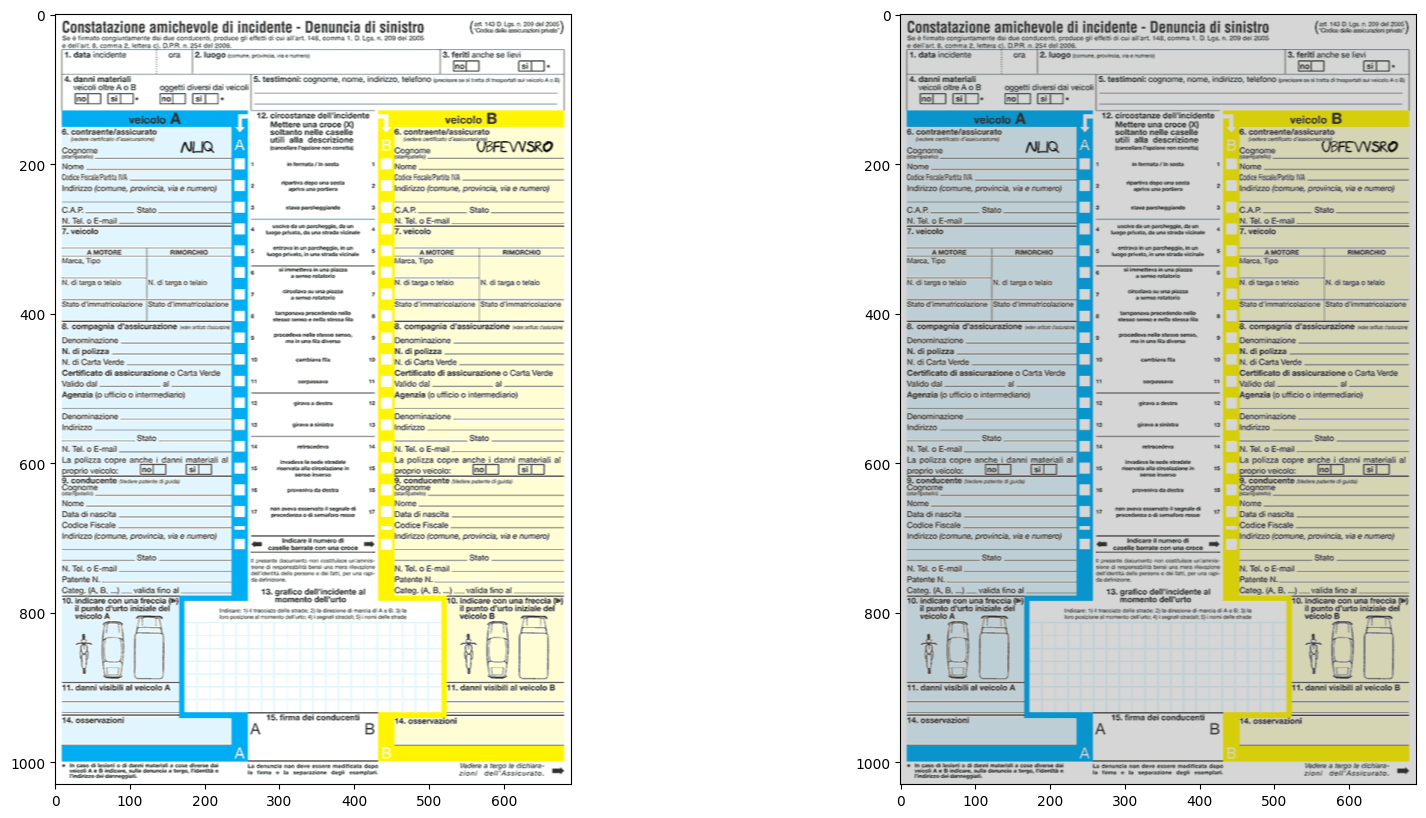

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(new_image_brightness_contrast, cv2.COLOR_BGR2RGB))
plt.show()

#### wave distortion

In [27]:
conf.get_params_range(WaveDistortionDegradation)

{'amplitude': [1, 2, 3, 4],
 'frequency': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]}

In [28]:
boxes_labels = [{"coords": coords} for coords in box_coords]

In [29]:
distorted_image, new_boxes_labels = WaveDistortionDegradation(parameters={"amplitude": 4, 
                                                        "frequency": 0.008}).apply(sample_image, boxes_labels=boxes_labels)

2025-04-14 00:08:08,090 - jobs.logging_config - DEBUG - Applying degradation WaveDistortionDegradation with parameters: {'amplitude': 4, 'frequency': 0.008}


In [30]:
boxes_labels

[{'coords': [[563, 169], [667, 169], [667, 186], [563, 186]]},
 {'coords': [[167, 169], [214, 169], [214, 187], [167, 187]]}]

In [31]:
new_boxes_labels

[{'coords': [[559, 169], [666, 169], [666, 186], [559, 186]]},
 {'coords': [[163, 169], [213, 169], [213, 187], [163, 187]]}]

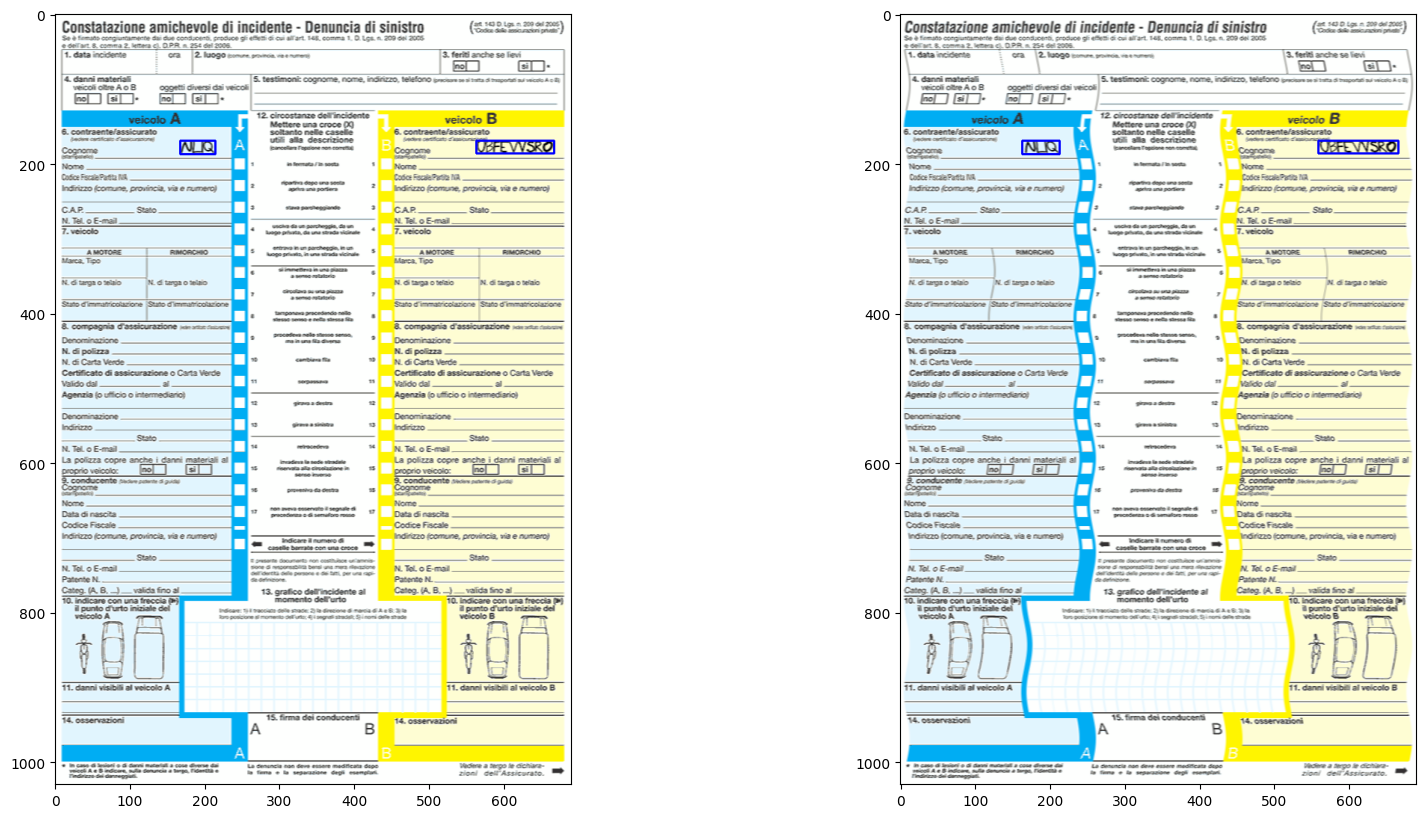

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(draw_boxes(sample_image, map(lambda x: x["coords"], boxes_labels)), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(draw_boxes(distorted_image, map(lambda x: x["coords"], new_boxes_labels)), cv2.COLOR_BGR2RGB))
plt.show()

### shadow

In [44]:
conf.get_params_range(ShadowDegradation)

{'direction': ['diagonal', 'left', 'right', 'top', 'bottom'],
 'intensity': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5],
 'blur': [50, 100, 150, 200, 250],
 'len_percentage': [0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6000000000000001,
  0.7000000000000001,
  0.8]}

In [52]:
shadow_image = ShadowDegradation(parameters={"direction": "left",
                                             "intensity": 0.5,
                                             "blur": 50,
                                             "len_percentage": 0.5}).apply(sample_image)

2025-04-13 21:06:24,558 - logging_config - DEBUG - Applying degradation with parameters: {'direction': 'left', 'intensity': 0.5, 'blur': 50, 'len_percentage': 0.5}


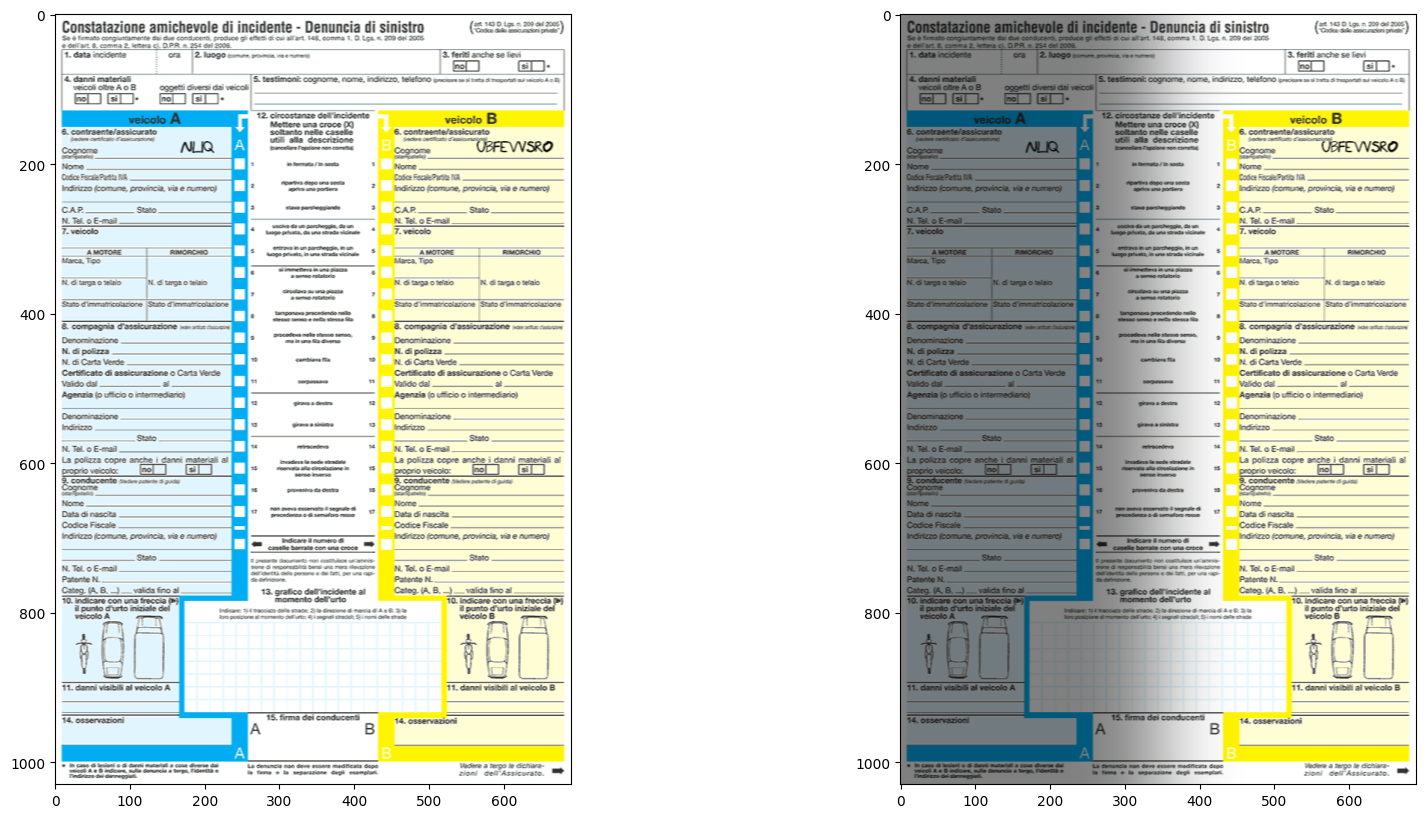

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(shadow_image, cv2.COLOR_BGR2RGB))
plt.show()

### color filter

In [42]:
conf.get_params_range(ColorFilterDegradation)

{'red': [0.9,
  0.91,
  0.92,
  0.93,
  0.9400000000000001,
  0.9500000000000001,
  0.9600000000000001,
  0.9700000000000001,
  0.9800000000000001,
  0.9900000000000001,
  1.0,
  1.0100000000000002,
  1.02,
  1.0300000000000002,
  1.04,
  1.0500000000000003,
  1.06,
  1.0700000000000003,
  1.08,
  1.0900000000000003,
  1.1],
 'green': [0.9,
  0.91,
  0.92,
  0.93,
  0.9400000000000001,
  0.9500000000000001,
  0.9600000000000001,
  0.9700000000000001,
  0.9800000000000001,
  0.9900000000000001,
  1.0,
  1.0100000000000002,
  1.02,
  1.0300000000000002,
  1.04,
  1.0500000000000003,
  1.06,
  1.0700000000000003,
  1.08,
  1.0900000000000003,
  1.1],
 'blue': [0.9,
  0.91,
  0.92,
  0.93,
  0.9400000000000001,
  0.9500000000000001,
  0.9600000000000001,
  0.9700000000000001,
  0.9800000000000001,
  0.9900000000000001,
  1.0,
  1.0100000000000002,
  1.02,
  1.0300000000000002,
  1.04,
  1.0500000000000003,
  1.06,
  1.0700000000000003,
  1.08,
  1.0900000000000003,
  1.1]}

In [31]:
color_filter_image = ColorFilterDegradation(parameters={"red": 1.1,
                                                        "green": 0.9,
                                                        "blue": 1}).apply(sample_image)

2025-04-13 22:28:40,015 - logging_config - DEBUG - Applying degradation with parameters: {'red': 1.1, 'green': 0.9, 'blue': 1}


In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(color_filter_image, cv2.COLOR_BGR2RGB))
plt.show()

### Apply Random Degradations

In [46]:
from sample_generation.image_degradations import  ImageDegradator
import random

In [47]:
degradations_list = [GaussianBlurDegradation, MotionBlurDegradation, GaussianNoiseDegradation, 
                     SaltPepperNoiseDegradation, BrightnessContrastDegradation, 
                     WaveDistortionDegradation, ShadowDegradation, ColorFilterDegradation]

In [37]:
n_degradations = random.randint(0, len(degradations_list))
random_degradations = random.sample(degradations_list, n_degradations)
random_degradations

[sample_generation.image_degradations.WaveDistortionDegradation,
 sample_generation.image_degradations.BrightnessContrastDegradation,
 sample_generation.image_degradations.ColorFilterDegradation,
 sample_generation.image_degradations.ShadowDegradation,
 sample_generation.image_degradations.SaltPepperNoiseDegradation,
 sample_generation.image_degradations.GaussianNoiseDegradation,
 sample_generation.image_degradations.MotionBlurDegradation]

In [49]:
boxes_labels = [{"coords": coords} for coords in box_coords]

In [50]:
image_degradator = ImageDegradator(image=sample_image, boxes_labels=boxes_labels, degradations_list=random_degradations, degradations_config=conf)

In [55]:
degradated_image, new_boxes_labels = image_degradator.apply_degradations()

2025-04-13 22:32:58,150 - logging_config - DEBUG - Applying degradation: WaveDistortionDegradation
2025-04-13 22:32:58,150 - logging_config - DEBUG - Applying degradation with parameters: {'amplitude': 2, 'frequency': 0.003}
2025-04-13 22:32:58,165 - logging_config - DEBUG - Applying degradation: BrightnessContrastDegradation
2025-04-13 22:32:58,166 - logging_config - DEBUG - Applying degradation with parameters: {'alpha': 1.1, 'beta': -15}
2025-04-13 22:32:58,167 - logging_config - DEBUG - Applying degradation: ColorFilterDegradation
2025-04-13 22:32:58,168 - logging_config - DEBUG - Applying degradation with parameters: {'red': 1.1, 'green': 0.9900000000000001, 'blue': 0.91}
2025-04-13 22:32:58,597 - logging_config - DEBUG - Applying degradation: ShadowDegradation
2025-04-13 22:32:58,598 - logging_config - DEBUG - Applying degradation with parameters: {'direction': 'left', 'intensity': 0.2, 'blur': 200, 'len_percentage': 0.6000000000000001}
2025-04-13 22:32:58,666 - logging_config - 

In [65]:
boxes_labels

[{'coords': [[563, 169], [667, 169], [667, 186], [563, 186]]},
 {'coords': [[167, 169], [214, 169], [214, 187], [167, 187]]}]

In [66]:
new_boxes_labels

[{'coords': [[564, 169], [670, 169], [670, 186], [564, 186]]},
 {'coords': [[168, 169], [217, 169], [217, 187], [168, 187]]}]

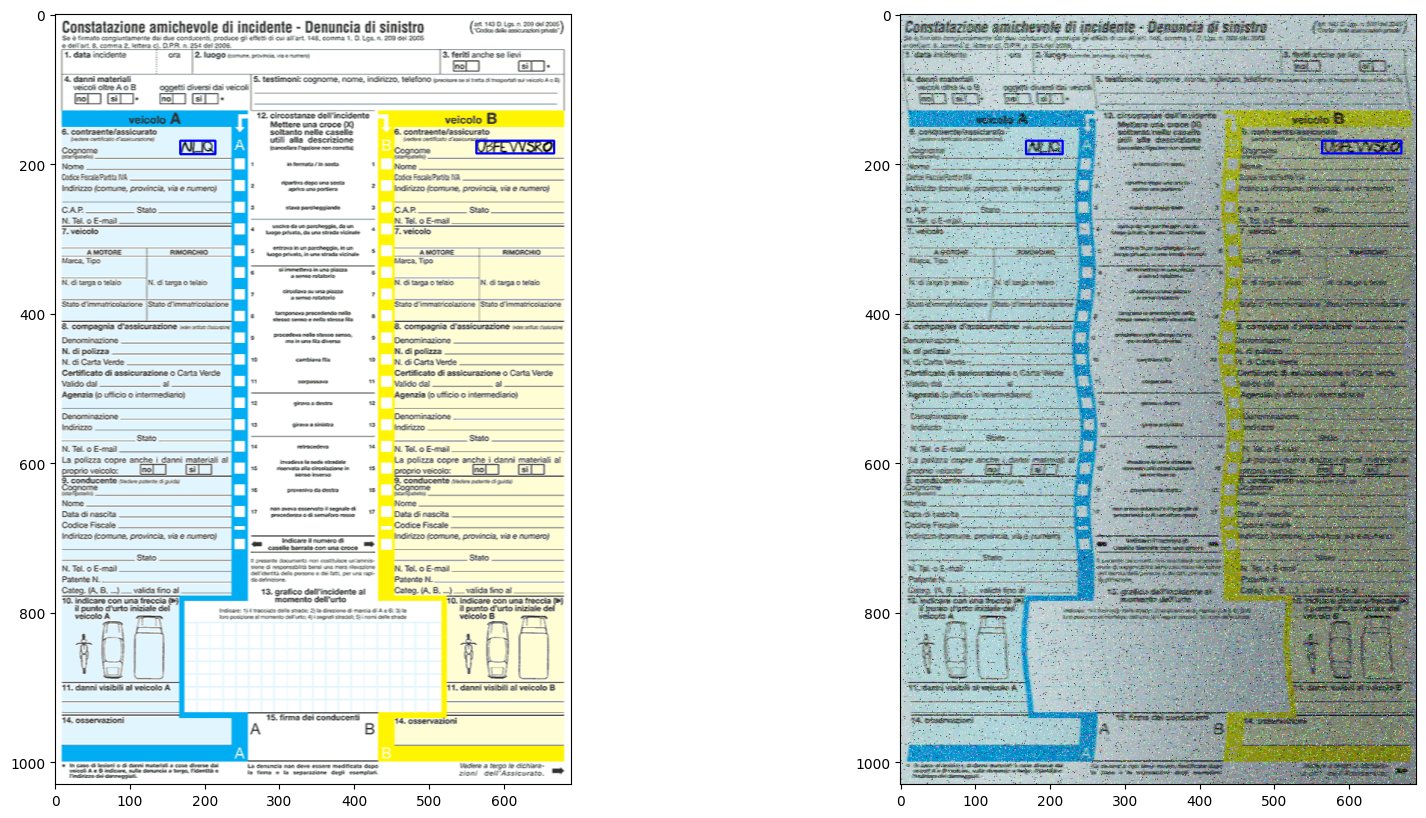

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(cv2.cvtColor(draw_boxes(sample_image, map(lambda x: x["coords"], boxes_labels)), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(draw_boxes(degradated_image, map(lambda x: x["coords"], new_boxes_labels)), cv2.COLOR_BGR2RGB))
plt.show()